### Create synoptic weather map for May, June, July, August 2023 using daily ERA5 data

In [1]:
# ------------------------------- #                   
# Maurice F. Huguenin             #
# m.huguenin-virchaux@unsw.edu.au #
# 30/01/2024, 10:06 AEDT          # 
# ------------------------------- #                   
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/NASST_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                                                                                       
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import pandas as pd
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
from wrf import to_np # conversion to arrays required for arrows on maps    
import sys
import warnings
import matplotlib.path as mpath
import time
import matplotlib.animation as animation # library that makes the movie
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
import bottleneck as bn # for time series moving average
from scipy import stats # create linear trend over the 3rd to 5th cycles for the upper 2000 m

#import warnings
#warnings.filterwarnings('ignore') # suppress warnings

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

from dask.distributed import Client
client = Client(n_workers=16)        
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Create daily fields from 3-hourly fields for each year, then create anomalies from that using the 1980-2010 climatology

In [2]:
%%time
session = cc.database.create_session()
import matplotlib.path as mpath 
# -------------------------------------------------------------------------------------------- #
NA_lat        = [    60,    361] # [    60,    361] = 75°N - 0°                                #
NA_lon        = [   320,    801] # [   320,    801] = 100°W - 20°E                             #
time          = [350650, 613633] # [350650, 613633] = 1980-01-01T00:00:00, 2010-01-01T01:00:00 #
# -------------------------------------------------------------------------------------------- #
era_path          = '/g/data/rt52/era5/single-levels/reanalysis/'
era_path_pressure = '/g/data/rt52/era5/pressure-levels/reanalysis/'
vars  = [  'sp',  '2t',     'u',     'v', 'sshf', 'ssrd', 'strd'] 
vars2 = [  'sp', 't2m',     'u',     'v', 'sshf', 'ssrd', 'strd']
units = ['[Pa]', '[K]', '[m/2]', '[m/s]', ]

# Step I:     calculating daily climatology for the variable
for f in [2,3]:#range(len(vars)):
    if vars[f] in ['u', 'v']:
        era_path = era_path_pressure # overwrite the path to get to the correct folder

    # create a new folder to store the data if it does not yet exist
    if not os.path.isdir('/g/data/e14/mv7494/ERA5/'+vars[f]):
        print('creating folder')
        os.mkdir('/g/data/e14/mv7494/ERA5/'+vars[f])
    filename = '/g/data/e14/mv7494/ERA5/'+vars[f]+'/ERA5_NorthAtlantic_'  

    for year in range(1959,2024): # loop through the climatological 1980-2010 period
        if os.path.exists(filename+vars[f]+'_daily_'+str(year)+'.nc'):
            print(str(year)+' already done')
            continue # skip iteration if the file has already been done before
        print('Preparing daily '+vars[f]+' for year '+ str(year))
        if vars[f] in ['u', 'v']:
            data = xr.open_mfdataset(era_path + vars[f] + '/'+str(year)+'/*.nc', chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'}
                                         )[vars2[f]][:,-1,NA_lat[0]:NA_lat[1],NA_lon[0]:NA_lon[1]].resample(time='D').mean()
        else:
            data = xr.open_mfdataset(era_path + vars[f] + '/'+str(year)+'/*.nc', chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'}
                                     )[vars2[f]][:,NA_lat[0]:NA_lat[1],NA_lon[0]:NA_lon[1]].resample(time='D').mean()
        data = data.to_dataset(name=vars[f]).to_netcdf(filename+vars[f]+'_daily_'+str(year)+'.nc')
    print('--------------------------')
    # Wall time: 1min for one year

# Step II: now creating daily climatology over all years
    data_clim       = xr.open_mfdataset(filename+vars[f]+'_daily_*.nc', chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'}, decode_times=True)[vars[f]][7670:18629]
    for year in range(1959,2024):
        if os.path.exists(filename+vars[f]+'_daily_anomalies_'+str(year)+'.nc'):
            print('Daily anomalies for ' + str(year)+' already done')
            continue # skip again if already done
        print('Preparing daily '+vars[f]+' anomalies for year '+ str(year))

        # open the previously saved data and calculate anomalies by removing the daily climatology over the 1980-2010 period
        data            = xr.open_mfdataset(filename+vars[f]+'_daily_'+str(year)+'.nc', chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'}, decode_times=True)[vars[f]]
        data_day_anom = (data.groupby('time.dayofyear') - data_clim.groupby('time.dayofyear').mean('time')).to_dataset(name=vars[f]+'_day_anom')
        
        # add attributes
        data_day_anom.attrs = {'Units': units[f], 
                           'Project': 'North Atlantic Ocean Heat Wave 2023',
                           'Author': 'Maurice F. Huguenin', 
                           'Data set': 'ERA5 reanalysis',
                            'Climatology': '1980-2010 daily climatology',
                           'Created': '2024-01-29', 
                           'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                           'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
        data_day_anom.to_netcdf(filename+vars[f]+'_daily_anomalies_'+str(year)+'.nc') # save anomaly file for each year
# Wall time: 1min for one year
# Wall time: 1h 37min 56s for all years and anomalies

1959 already done
1960 already done
1961 already done
1962 already done
1963 already done
1964 already done
1965 already done
1966 already done
1967 already done
1968 already done
1969 already done
1970 already done
1971 already done
1972 already done
1973 already done
1974 already done
1975 already done
1976 already done
1977 already done
1978 already done
1979 already done
1980 already done
1981 already done
1982 already done
1983 already done
1984 already done
1985 already done
1986 already done
1987 already done
1988 already done
1989 already done
1990 already done
1991 already done
1992 already done
1993 already done
1994 already done
1995 already done
1996 already done
1997 already done
1998 already done
1999 already done
2000 already done
2001 already done
2002 already done
2003 already done
2004 already done
2005 already done
2006 already done
2007 already done
2008 already done
2009 already done
2010 already done
2011 already done
2012 already done
2013 already done
2014 alrea

### Plotting routine for the North Atlantic

In [3]:
# load in fields for plotting and convert sea level pressure anomalies to [hPa]
slp_field = (xr.open_mfdataset('/g/data/e14/mv7494/ERA5/sp/ERA5_NorthAtlantic_sp_daily_anomalies_2023.nc')['sp_day_anom'].groupby('time.month').mean('time')[4:8,:,:] / 100).load()
t2m_field = (xr.open_mfdataset('/g/data/e14/mv7494/ERA5/2t/ERA5_NorthAtlantic_2t_daily_anomalies_2023.nc')['2t_day_anom'].groupby('time.month').mean('time')[4:8,:,:]).load()
u_field = (xr.open_mfdataset('/g/data/e14/mv7494/ERA5/u/ERA5_NorthAtlantic_u_daily_anomalies_2023.nc')['u_day_anom'].groupby('time.month').mean('time')[4:8,:,:]).load()
v_field = (xr.open_mfdataset('/g/data/e14/mv7494/ERA5/v/ERA5_NorthAtlantic_v_daily_anomalies_2023.nc')['v_day_anom'].groupby('time.month').mean('time')[4:8,:,:]).load()
lon, lat = np.meshgrid(slp_field.longitude, slp_field.latitude)

In [4]:
%%time
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        # hmaurice: size = 24 at the beginning and not bold
        # hmaurice: add set_path_effects to highlight the symbols with an outline
        ax1.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=16,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                weight='bold', transform=transform).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(lon[mxy[i], mxx[i]+8], lat[mxy[i], mxx[i]], # hmaurice: mxx[i]+8] slight shift +8 
                '\n' + str(np.int(data[mxy[i], mxx[i]])),
                color=color, size=8, clip_on=True, fontweight='bold',
                horizontalalignment='left', verticalalignment='center', transform=transform).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])


import matplotlib.path as mpath 
def fancy_plot(ax):
    # ax.gridlines()
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'darkgrey', facecolor = [.83,.83,.83], zorder = 1)

CPU times: user 7 µs, sys: 10 µs, total: 17 µs
Wall time: 24.1 µs


CPU times: user 53.2 s, sys: 5.96 s, total: 59.2 s
Wall time: 55.8 s


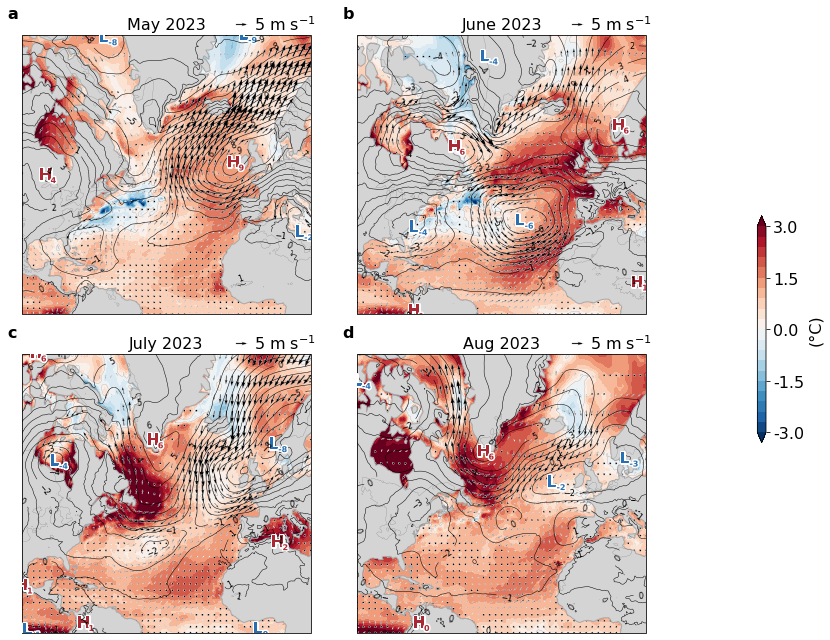

In [5]:
%%time
# initialise figure
fig = plt.figure(figsize=(12,9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2) 

for f in range(4): # loop through the four panels
    slp = slp_field[f,:,:] 
    t2m = t2m_field[f,:,:] 
    ticks=np.linspace(-10,10,21); ticks2=np.linspace(-3,3,21);
    cbar_label='(°C)'
    if f == 0: panel=gs[0,0]; title_str = 'May 2023'
    if f == 1: panel=gs[0,1]; title_str = 'June 2023'
    if f == 2: panel=gs[1,0]; title_str = 'July 2023'
    if f == 3: panel=gs[1,1]; title_str = 'Aug 2023'
        
    ax1 = plt.subplot(panel, projection=ccrs.Mercator(central_longitude=-60))#(min_latitude=0, max_latitude=75))
    # ax1 = plt.subplot(panel, projection=ccrs.LambertConformal(central_latitude=37, central_longitude=-60))
    ax1.set_extent([-100, 20, 0, 75], crs=ccrs.PlateCarree()) # extent of plot
    # ----------------------------------------------------------------------------------------------------------------------------------- # 
    p1  = t2m.plot.contourf(ax=ax1,levels=ticks2,cmap='RdBu_r', extend='both',add_colorbar=False,transform=ccrs.PlateCarree())
    p11 = t2m.plot.contour(levels = [0], linewidths=.1,cmap='k',transform=ccrs.PlateCarree())
    p2  = slp.plot.contour(ax=ax1,levels=ticks,cmap='k', linewidths=.5, extend='both',add_colorbar=False,transform=ccrs.PlateCarree())
    ax1.clabel(p2, p2.levels, inline=True, fontsize=8, colors='k')

    # specifics for the wind speed arrows
    X = u_field.longitude; Y = v_field.latitude
    U = u_field[f,:,:]; V = v_field[f,:,:]
    # widths = np.linspace(-.0001, .0001, X.size)
    # Add the wind stress arrows, only plotting every 30th data point.
    abstand = 10
    Q = plt.quiver(to_np(X[::abstand]),   to_np(Y[::abstand]), 
               to_np(U[::abstand, ::abstand]), to_np(V[::abstand, ::abstand]), 
               scale=120, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), width=.0075, linewidths=.3, edgecolor=('w')) 
                          # minshaft = select minimum sized arrow (i.e., only those larger than 2)
    # reference key on the map 
    qk = plt.quiverkey(Q, .78, 1.04, 5, r'5 m s$^{-1}$', labelpos='E', fontproperties={'size':16})
    # ----------------------------------------------------------------------------------------------------------------------------------- #
    fancy_plot(ax1); plt.title(title_str, fontsize=16)
    plot_maxmin_points(lon, lat, slp_field[f,:,:], 'max', 200, 'H', color=rotblau[  3],  transform= ccrs.PlateCarree())
    plot_maxmin_points(lon, lat, slp_field[f,:,:], 'min', 200, 'L', color=rotblau[ 17],  transform= ccrs.PlateCarree())
    
    ax1.text(-.05, 1.06, string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # panel label

# add colour bar 
cax = fig.add_axes([.99, .31, .01, .35]) # position: [x0, y0, width, height]
from matplotlib.ticker import FuncFormatter
fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical', format=FuncFormatter(fmt)); 
cb_txt = cb.set_label(label='(°C)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator;cb.update_ticks()

# cb.add_lines(p11) # add contours to colour bar  
# --- saving as 300 dpi .PNG image in specified folder ----------------------------------------------- #
filename = 'synoptic_weather_situation_monthly_mean_path'                                              #
plt.savefig(save + filename, dpi=300, facecolor='w', edgecolor='w', orientation='landscape',           #
            format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)        #
# --- end of script ---------------------------------------------------------------------------------- #
# # Wall time: 5min 25s

**TODO**:
- useful link to create synoptic weather chart: https://unidata.github.io/python-gallery/examples/HILO_Symbol_Plot.html
- add SSTs
- add white highlighting for H and L
- add colour bar
- add 2 pv line?
- replace SLP with geopotential height at 500 hPa

### Next step, doing the same map but weekly

In [6]:
# select week 18 - 34 (May - June - July - August)
slp_field = xr.open_mfdataset('/g/data/e14/mv7494/ERA5/sp/ERA5_NorthAtlantic_sp_daily_anomalies_2023.nc')['sp_day_anom'].groupby('time.week').mean('time')[17:33,:,:].load()
t2m_field = xr.open_mfdataset('/g/data/e14/mv7494/ERA5/2t/ERA5_NorthAtlantic_2t_daily_anomalies_2023.nc')['2t_day_anom'].groupby('time.week').mean('time')[17:33,:,:].load()

In [7]:
%%time
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color
    lon = plotting longitude values (2D)
    lat = plotting latitude values (2D)
    data = 2D data that you wish to plot the max/min symbol placement
    extrema = Either a value of max for Maximum Values or min for Minimum Values
    nsize = Size of the grid box to filter the max and min values to plot a reasonable number
    symbol = String to be placed at location of max/min value
    color = String matplotlib colorname to plot the symbol (and numerica value, if plotted)
    plot_value = Boolean (True/False) of whether to plot the numeric value of max/min point
    The max/min symbol will be plotted on the current axes within the bounding frame
    (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        # hmaurice: size = 24 at the beginning and not bold
        # hmaurice: add set_path_effects to highlight the symbols with an outline
        ax1.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=16,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                weight='bold', transform=transform) 
        ax1.text(lon[mxy[i], mxx[i]+8], lat[mxy[i], mxx[i]], # hmaurice: mxx[i]+8] slight shift +8 
                '\n' + str(np.int(data[mxy[i], mxx[i]])),
                color=color, size=8, clip_on=True, fontweight='bold',
                horizontalalignment='left', verticalalignment='center', transform=transform)  

CPU times: user 5 µs, sys: 5 µs, total: 10 µs
Wall time: 16 µs


Preparing figure for month May
Preparing figure for month June
Preparing figure for month July
Preparing figure for month August
CPU times: user 19min 26s, sys: 4min, total: 23min 27s
Wall time: 18min 33s


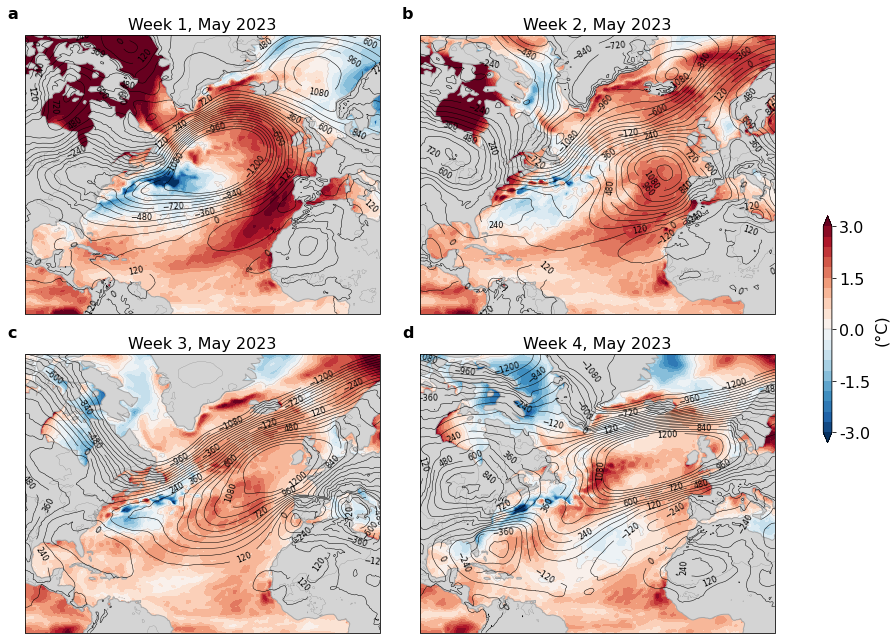

In [8]:
%%time
import matplotlib.path as mpath 
def fancy_plot(ax):
    # ax.gridlines()
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'darkgrey', facecolor = [.83,.83,.83], zorder = 1)

for w in [0, 4, 8, 12]: # loop through the weeks from May to end of August
    if w  == 0: monat =    'May' # wochen 0, 1, 2, 3
    if w  == 4: monat =   'June' # wochen 4, 5, 6, 7
    if w  == 8: monat =   'July' # wochen 8, 9, 10, 11
    if w == 12: monat = 'August' # wochen 12, 13, 14, 15
    print('Preparing figure for month ' + monat)
    # initialise figure
    fig = plt.figure(figsize=(12,9),tight_layout=True,facecolor='w',edgecolor='k')
    gs = gridspec.GridSpec(2,2) 
    
    for f in range(4): # loop through the four panels
        ticks=np.linspace(-1200,1200,21); ticks2=np.linspace(-3,3,21)
        cbar_label='(°C)'
        if f == 0: panel=gs[0,0]; slp = slp_field[w+f,:,:]; t2m = t2m_field[w+f,:,:]; title_str = 'Week 1, '+monat+' 2023'
        if f == 1: panel=gs[0,1]; slp = slp_field[w+f,:,:]; t2m = t2m_field[w+f,:,:]; title_str = 'Week 2, '+monat+' 2023'
        if f == 2: panel=gs[1,0]; slp = slp_field[w+f,:,:]; t2m = t2m_field[w+f,:,:]; title_str = 'Week 3, '+monat+' 2023'
        if f == 3: panel=gs[1,1]; slp = slp_field[w+f,:,:]; t2m = t2m_field[w+f,:,:]; title_str = 'Week 4, '+monat+' 2023'
            
        ax1 = plt.subplot(panel, projection=ccrs.Miller(central_longitude=-60))#(min_latitude=0, max_latitude=75))
        # ax1 = plt.subplot(panel, projection=ccrs.LambertConformal(central_latitude=37, central_longitude=-60))
        ax1.set_extent([-100, 20, 0, 75], crs=ccrs.PlateCarree()) # extent of plot
        # ----------------------------------------------------------------------------------------------------------------------------------- # 
        p1  = t2m.plot.contourf(ax=ax1,levels=ticks2,cmap='RdBu_r', extend='both',add_colorbar=False,transform=ccrs.PlateCarree())
        p11 = t2m.plot.contour(levels = [0], linewidths=.1,cmap='k',transform=ccrs.PlateCarree())
        p2  = slp.plot.contour(ax=ax1,levels=ticks,cmap='k', linewidths=.5, extend='both',add_colorbar=False,transform=ccrs.PlateCarree())
        ax1.clabel(p2, p2.levels, inline=True, fontsize=8, colors='k')
        # ----------------------------------------------------------------------------------------------------------------------------------- #
        fancy_plot(ax1); plt.title(title_str, fontsize=16)
        # plot_maxmin_points(lon, lat, slp_field[w+f,:,:], 'max', 200, 'H', color=rotblau[17],  transform= ccrs.PlateCarree())
        # plot_maxmin_points(lon, lat, slp_field[w+f,:,:], 'min', 200, 'L', color=rotblau[ 3],  transform= ccrs.PlateCarree())
        
        ax1.text(-.05, 1.06, string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # panel label
    
    # add colour bar 
    cax = fig.add_axes([.99, .31, .01, .35]) # position: [x0, y0, width, height]
    from matplotlib.ticker import FuncFormatter
    fmt = lambda x, pos: '{:.2}'.format(x)                              # format tick labels so that I have (-.5, -.25,0,.25,.5)
    cb = plt.colorbar(p1, cax = cax, shrink=.5, orientation='vertical', format=FuncFormatter(fmt)); 
    cb_txt = cb.set_label(label='(°C)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks()
    cb.add_lines(p11) # add contours to colour bar  
    # --- saving as 300 dpi .PNG image in specified folder ----------------------------------------------- #
    filename = 'synoptic_weather_situation_weekly_mean_week_'+ monat                                       #
    plt.savefig(save + filename, dpi=300, facecolor='w', edgecolor='w', orientation='landscape',           #
                format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)        #
    # --- end of script ---------------------------------------------------------------------------------- #
    if w != 0: plt.close(fig) # close figure if it's not the first one
# # Wall time: 5min 25s

In [9]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #